In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Extrai o dataset SPIE-AAPM Lung CT Challenge do drive. O conjunto de imagens pode ser acessado no link abaixo:
  - https://wiki.cancerimagingarchive.net/display/Public/SPIE-AAPM+Lung+CT+Challenge#19039197a19462154cc74bea92039089e61a0f44
"""

!unzip -q /content/drive/MyDrive/TCC/dataset.zip

In [ ]:
"""
O código abaixo realiza as seguintes operações:
  - Redimensiona as imagens para um tamanho especificado;
  - Define um tamanho de lote para o treinamento do modelo;
  - Divide as imagens em conjuntos de treinamento e validação;
  - Imprime o nome das classes do dataset.
"""

IMAGE_SIZE = (180,180)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

train_ds.class_names

Found 19084 files belonging to 2 classes.
Using 15268 files for training.
Found 19084 files belonging to 2 classes.
Using 3816 files for validation.


['benign', 'malignant']

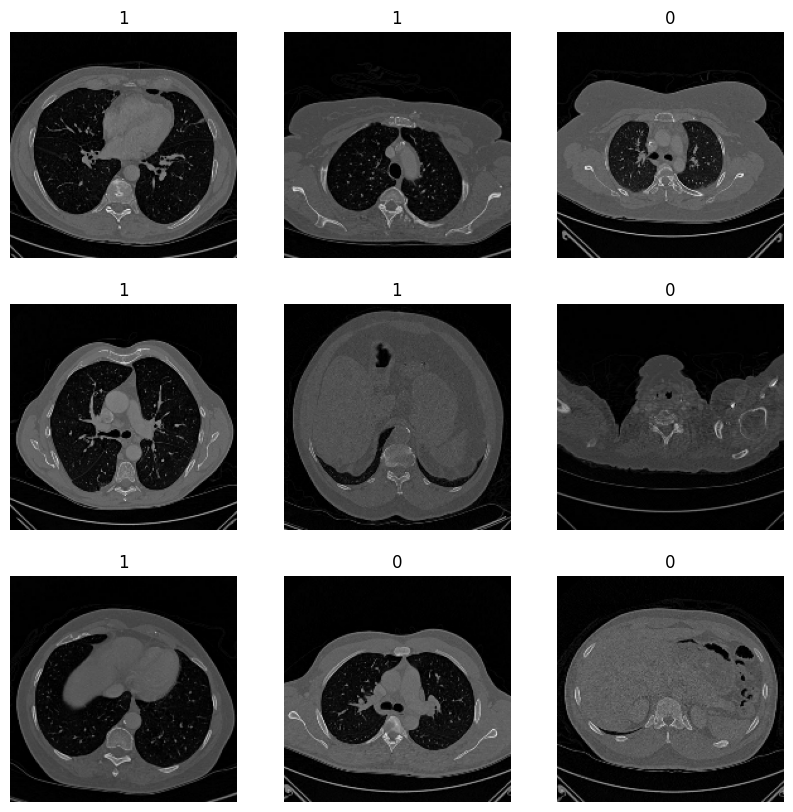

In [ ]:
"""
Esse código cria uma figura com nove subplots e plota nove imagens aleatórias do conjunto
de treinamento do modelo - que contém tumores benignos (0) e malignos (1).
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [ ]:
"""
Realiza o processo de data augmentation nas imagens:
  - Aplica uma operação de espelhamento horizontal aleatório nas imagens de entrada;
  - Aplica uma rotação nas imagens de entrada com uma amplitude de até 0.1 radianos.
"""

from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
])

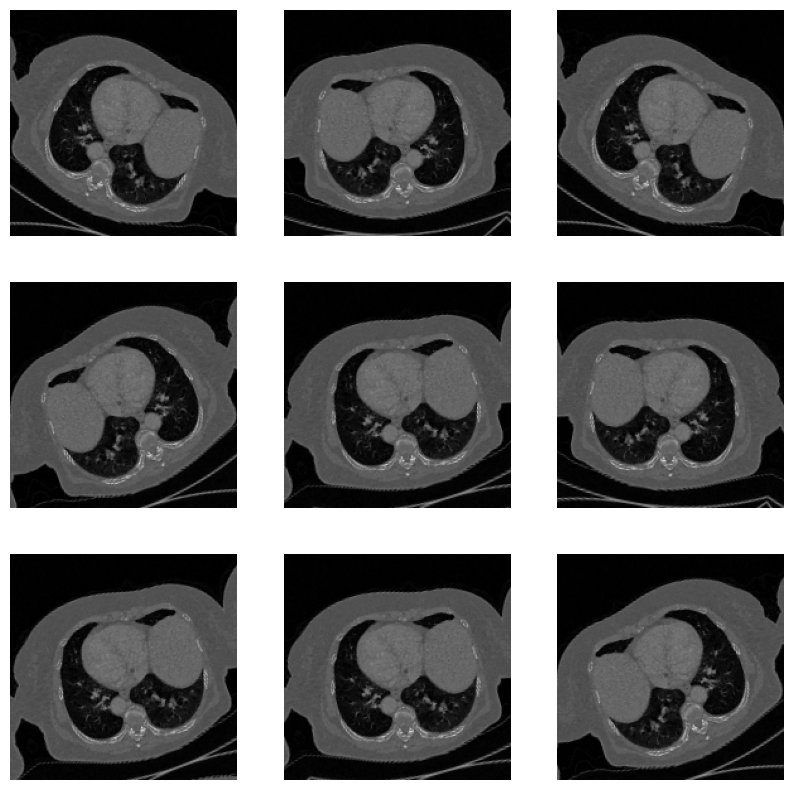

In [ ]:
"""
Exibe 10 imagens do dataset após o processo de data augmentation.
"""

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
"""
Permite que o conjunto de dados carregue 32 lotes de dados em segundo plano enquanto
o modelo está sendo treinado com o lote anterior.
"""

BUFFER_SIZE=32

train_ds = train_ds.prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.prefetch(buffer_size=BUFFER_SIZE)

94765736/94765736 [==============================] - 1s 0us/step


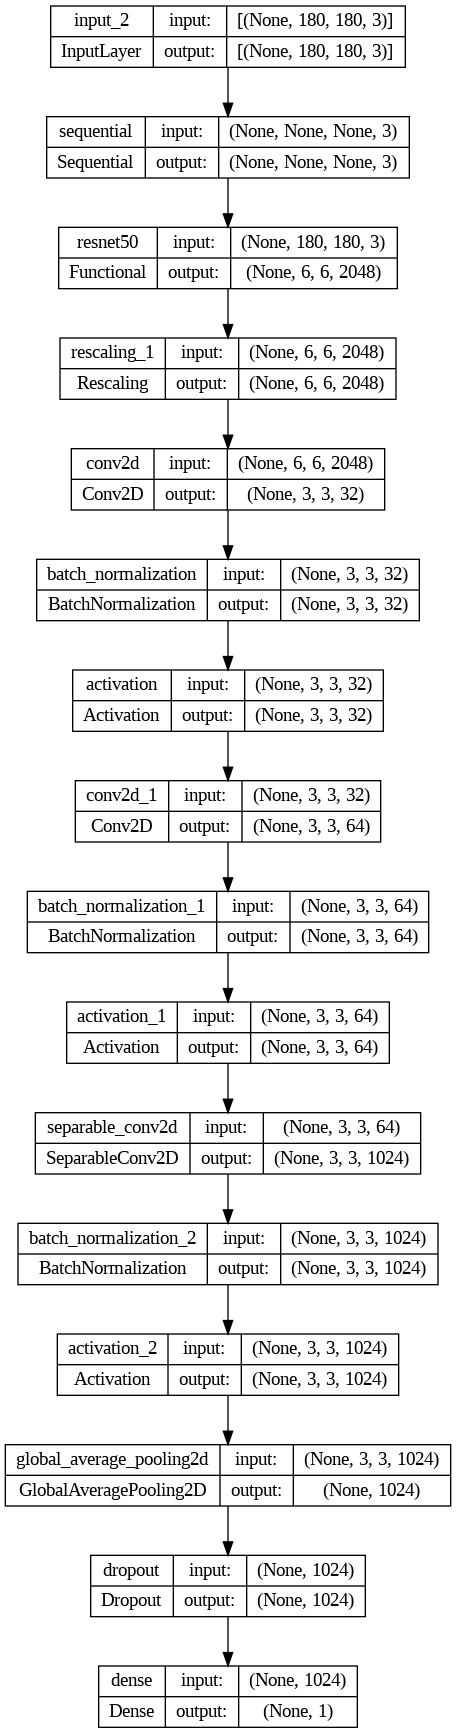

In [ ]:
"""
Constrói o modelo baseado na arquitetura ResNet50
"""

from keras.applications import ResNet50

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model(x)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    return keras.Model(inputs, outputs, name='resnet50')

model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=2)

keras.utils.plot_model(model, show_shapes=True)

In [13]:
"""
Executa o treinamento do modelo ResNet50
"""

EPOCHS=50

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
478/478 [==============================] - 188s 281ms/step - loss: 0.6767 - accuracy: 0.5888 - val_loss: 1.0789 - val_accuracy: 0.4463
Epoch 2/50
478/478 [==============================] - 132s 276ms/step - loss: 0.5617 - accuracy: 0.6935 - val_loss: 1.0669 - val_accuracy: 0.5943
Epoch 3/50
478/478 [==============================] - 132s 276ms/step - loss: 0.4718 - accuracy: 0.7657 - val_loss: 2.3231 - val_accuracy: 0.4641
Epoch 4/50
478/478 [==============================] - 132s 276ms/step - loss: 0.3767 - accuracy: 0.8250 - val_loss: 0.5097 - val_accuracy: 0.7605
Epoch 5/50
478/478 [==============================] - 134s 280ms/step - loss: 0.2959 - accuracy: 0.8717 - val_loss: 0.5754 - val_accuracy: 0.7741
Epoch 6/50
478/478 [==============================] - 134s 280ms/step - loss: 0.2382 - accuracy: 0.8974 - val_loss: 0.8593 - val_accuracy: 0.7327
Epoch 7/50
478/478 [==============================] - 133s 277ms/step - loss: 0.1734 - accuracy: 0.9329 - val_loss: 0.8603 -

In [14]:
"""
Método que utiliza o modelo treinado para classificar uma imagem
"""

def classify_image(image_path):
  img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = predictions[0]
  benign = 100 * (1 - score)
  malignant = 100 * score

  print("This image is %.2f%% benign and %.2f%% malignant." % (benign, malignant))

In [15]:
"""
Testa o modelo classificando uma imagem com tumor benigno
"""

classify_image('dataset/benign/011-001.jpg')

1/1 [==============================] - 2s 2s/step
This image is 99.42% benign and 0.58% malignant.


In [16]:
"""
Testa o modelo classificando uma imagem com tumor maligno
"""

classify_image('dataset/malignant/011-006.jpg')

1/1 [==============================] - 0s 24ms/step
This image is 0.09% benign and 99.91% malignant.
